In [18]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, NMF, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/df_oversamling.csv')
data.head()

,userId,wine,rate
0,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Montepulciano 60,1
1,4e0cbfe3-8d73-4af4-b09e-f3193d1170a5,Zahorra Blanca,1
2,20e0b694-84a5-4f11-9191-598f924c2947,Morellino di Scansano 2021,1
3,20e0b694-84a5-4f11-9191-598f924c2947,Morellino di Scansano 2021,1
4,5ccd8030-047b-432c-a630-d784ab415756,Bardolino Chiaretto,1


In [19]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','Biased','RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, Biased, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


## Non-Negative Matrix Factorization

In [20]:
class Nmf (NMF):
    def __init__(self, n_factors, n_epochs, biased, verbose):
       NMF.__init__(self, 
                    n_factors= n_factors, n_epochs = n_epochs,
                      biased= biased, verbose = verbose)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)
        
    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            NMF.fit(self, trainset_fold)
            train_prediction = NMF.test(self, trainset_fold.build_testset())
            prediction = NMF.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = NMF.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        '''Return the k nearest neighbors of user_id'''
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        '''Return the k nearest neighbors of item_id'''
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## SVD and SGD

The minimization is performed by a very straightforward stochastic gradient descent:
* note You can choose to use an unbiased version of this algorithm
* verbose – If True, prints the current epoch. Default is False.

In [21]:
nmf = Nmf(n_factors= 100, n_epochs= 60, biased= True, verbose=False)

nmf.create_reader(data)
predictions = nmf.fit()
#acc
metrics = nmf.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'Non-Negative Matrix Factorization'

metrics['Biased'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

RMSE: 1.1166
RMSE: 1.3227
RMSE: 1.4920
RMSE: 1.7088
RMSE: 1.1188
RMSE: 1.1381
RMSE: 1.5327
RMSE: 1.6751
RMSE: 1.0685
RMSE: 1.1158
###############################################
The Results are: 

Average RMSE on Training Set: 1.2657098460599505
Average RMSE on Test Set: 1.392109046030003
RMSE: 1.0305
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.030451223662132
RMSE: 1.0305
MAE:  0.6739
MSE: 1.0618
Precision: 0.35
Recall: 0.33
the acc is 55.64


/tmp/ipykernel_22939/3155765162.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [22]:
nmf2 = Nmf(n_factors= 100, n_epochs= 60, biased= False, verbose=False)

nmf2.create_reader(data)
predictions = nmf2.fit()
#acc
metrics = nmf2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'Non-Negative Matrix Factorization'

metrics['Biased'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

RMSE: 0.3682
RMSE: 0.6395
RMSE: 0.3582
RMSE: 0.6975
RMSE: 0.3681
RMSE: 0.5891
RMSE: 0.3744
RMSE: 0.6740
RMSE: 0.3406
RMSE: 0.6845
###############################################
The Results are: 

Average RMSE on Training Set: 0.3619137211321616
Average RMSE on Test Set: 0.6569319066260173
RMSE: 0.6538
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.653804935245916
RMSE: 0.6538
MAE:  0.4006
MSE: 0.4275
Precision: 0.34
Recall: 0.27
the acc is 71.39


/tmp/ipykernel_22939/3989888284.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_22939/3989888284.py:15: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [23]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,Biased,RMSE,MAE,MSE,Precision,Recall,Accuracy
1,2,Non-Negative Matrix Factorization,False,0.653805,0.400639,0.427461,0.340741,0.272619,71.391076
0,1,Non-Negative Matrix Factorization,True,1.030451,0.673945,1.061830,0.353831,0.325160,55.643045


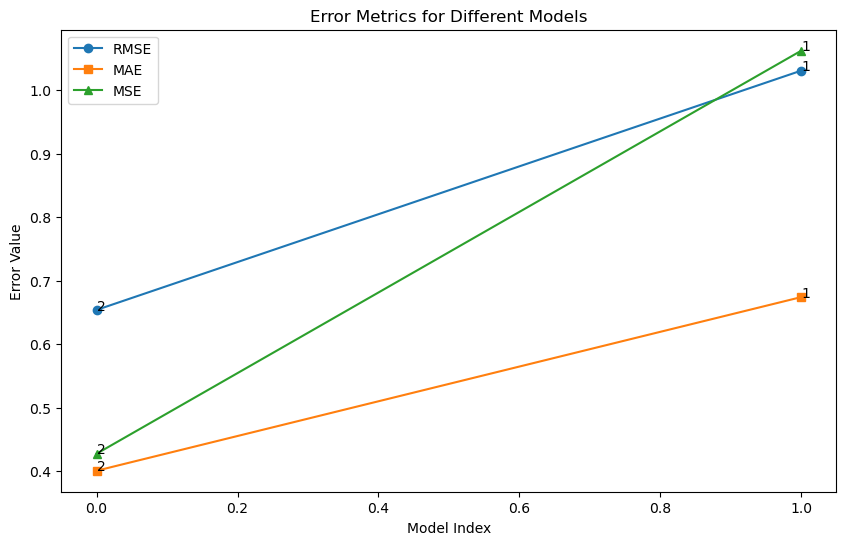

In [24]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

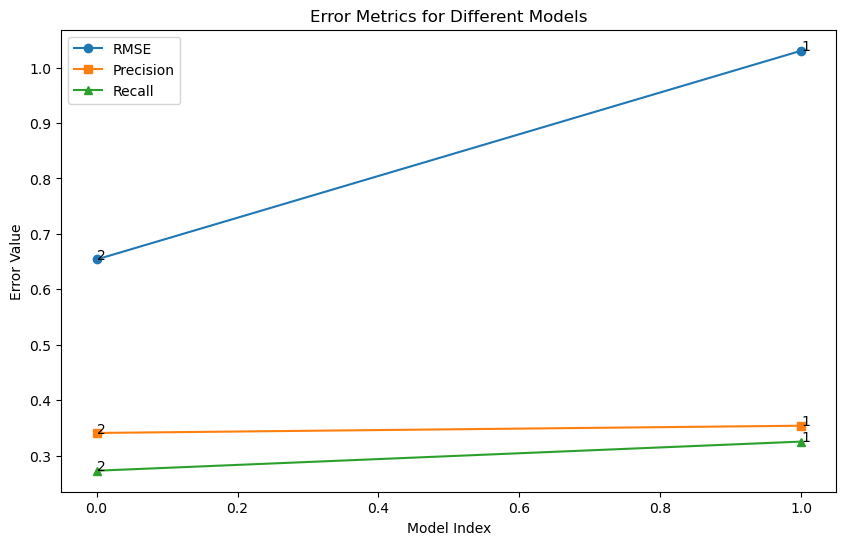

In [25]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

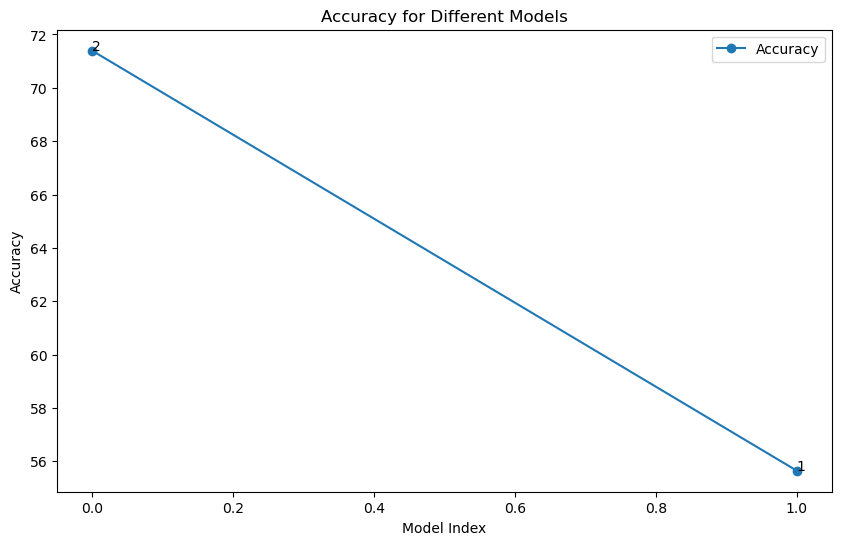

In [26]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [27]:
#recommends items for a given user from predictions

# user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
# top_n = KnnWithMeans.get_top_n_for_user(predictions, user_id)
# print(user_id, [iid for (iid, _) in top_n])
######### better print
user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
top_n = nmf.get_top_n_for_user(predictions, user_id)
print(f"Top items for the user '{user_id}' are:")
for i, (iid, _) in enumerate(top_n, 1):
    print(f"{i}. Item ID: {iid}")

Top items for the user '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7' are:
1. Item ID: Le Relais de Patache d'Aux
2. Item ID: Anjou Blanc
3. Item ID: Valle Central Merlot
4. Item ID: Senorino de Baldios
5. Item ID: Valle Central Merlot
6. Item ID: Les Fossiles Riesling
7. Item ID: Fleurie Grand Pre
8. Item ID: Théophile Brut Champagne
9. Item ID: Groot Constantia
10. Item ID: Valle de Maipo Carmenere


In [28]:
# recommneds users for a given item from predictions

# item_id = 'Chardonnay'
# top_n = KnnWithMeans.get_top_n_users_for_item(predictions, item_id)
# print(item_id, [uid for (uid, _) in top_n])
########## better print
item_id = 'Chardonnay'
top_n = nmf.get_top_n_users_for_item(predictions, item_id)
print(f"Top users for the item '{item_id}' are:")
for i, (uid, _) in enumerate(top_n, 1):
    print(f"{i}. User ID: {uid}")

Top users for the item 'Chardonnay' are:
1. User ID: 36fec3ea-e183-491d-b65a-6c7ac90fafa5
2. User ID: 9a3cc655-c88e-4c1b-95e2-add7579ff4c2
3. User ID: d48fd3bd-06e9-4368-97b9-aae545388325


In [29]:
#get the KnnWithMeans for a user from the model
nmf.get_neighbors_uid(user_id=5)

['f8c400a6-ded1-40b8-95d2-a263d05c30ce',
 '5ccd8030-047b-432c-a630-d784ab415756',
 '41375cb6-321d-410a-bd0b-d0afed9f0417',
 'bc79b0e3-064d-4240-86de-e86499f577e8',
 'ff89d8c1-48a3-49b5-af95-62d0ce9ecf55',
 '2a62eecd-b0cd-4395-9f8c-7c912a208be2',
 '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7',
 '9250d444-805f-4756-a03b-93a597ab320d',
 '25a04c51-5638-42f0-b2e7-ce49b1c280fc',
 'cec7ccd7-a556-4a79-a333-50619c4e4a9e']

In [30]:
#get the KnnWithMeans for an item from the model
nmf.get_neighbors_iid(item_id=20)

['LÖSS-LEHM Chardonnay & Weißer Burgunder',
 'Rosso piceno tenuta coccci grifoni',
 'Dettelbach Silvaner',
 'MLV Masseria Li Veli',
 '3／4 大亂鬥 7',
 'Grey (Glacier) Cabernet Sauvignon',
 'Chateauneuf du pape',
 'Vitovska',
 'Mendoza Chardonnay',
 'Soave classico']

In [31]:
nmf.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(nmf.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 12 with sim 0.144278606965174
user 12 with sim 0.144278606965174
user 12 with sim 0.144278606965174
user 12 with sim 0.144278606965174
user 12 with sim 0.144278606965174
And the baseline estimate is: 3.3265946912584488

#####

Note: If the baseline is 3.0081967213114753 then the value is a default value, Otherwise not


In [32]:
df_pred = nmf.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,bc79b0e3-064d-4240-86de-e86499f577e8,3／4 大亂鬥 6,1.0,1.131349,{'was_impossible': False},89,12,0.131349
1,441ac739-42f8-48d2-9526-fdedf2d4852f,Bollicina,3.0,3.356045,{'was_impossible': False},10,8,0.356045
2,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,Rheinhessen Kabinett Riesling,1.0,1.053556,{'was_impossible': False},76,16,0.053556
3,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,le vigne di zamò merlot 50 anni,3.0,3.164986,{'was_impossible': False},101,3,0.164986
4,e2723dcb-0b44-477f-bf74-678640f5c06d,Terrano,5.0,2.974590,"{'was_impossible': True, 'reason': 'User and i...",4,31,2.025410
5,5ccd8030-047b-432c-a630-d784ab415756,Maikammer Kapellenberg Chardonnay,4.0,2.974590,"{'was_impossible': True, 'reason': 'User and i...",123,0,1.025410
6,3dd9219a-c64e-4c5a-a61b-aad6a417a69a,Brachetto Piemonte,3.0,3.327776,{'was_impossible': False},3,4,0.327776
7,76b71bb0-6cc9-4168-8a45-bbafc1e9a256,Brunello di Montalcino Riserva Vigna Paganelli,4.0,4.471141,{'was_impossible': False},12,1,0.471141
8,9a3cc655-c88e-4c1b-95e2-add7579ff4c2,Chardonnay,3.0,3.950127,{'was_impossible': False},8,9,0.950127
9,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Brunello di Montlcino Mozard,3.0,2.974590,"{'was_impossible': True, 'reason': 'User and i...",140,1,0.025410


* best predictions

In [33]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
213,35bcb30c-a1b8-49c0-85e3-aaa84e30f50d,Rubicon,5.0,5.0,{'was_impossible': False},1,1,0.0
331,bc79b0e3-064d-4240-86de-e86499f577e8,Dolcetto d'Alba Classici,5.0,5.0,{'was_impossible': False},89,3,0.0
95,20e0b694-84a5-4f11-9191-598f924c2947,Morellino di Scansano 2021,1.0,1.0,{'was_impossible': False},12,12,0.0
332,4e9cb62e-a165-484b-ad78-cb215523cdd5,Le sol,5.0,5.0,{'was_impossible': False},2,2,0.0
93,7e32fee4-f7c4-4600-8a34-db7801ac79d5,Pas Dosé,5.0,5.0,{'was_impossible': False},3,2,0.0
92,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Rimosso,5.0,5.0,{'was_impossible': False},140,3,0.0
333,7e32fee4-f7c4-4600-8a34-db7801ac79d5,Trento Doc,5.0,5.0,{'was_impossible': False},3,0,0.0
89,ff89d8c1-48a3-49b5-af95-62d0ce9ecf55,Broad Run Pinot Noir,5.0,5.0,{'was_impossible': False},9,6,0.0
88,4eb7031c-da00-48f4-bc7f-0a1f1eda7cab,Malvasia,5.0,5.0,{'was_impossible': False},11,5,0.0
335,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Sori Tildin,5.0,5.0,{'was_impossible': False},140,1,0.0


* worst predictions

In [34]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
328,86ddb2c4-016f-47ed-8cf9-aa0a3564b7f8,Puntalice,5.0,2.974590,"{'was_impossible': True, 'reason': 'User and i...",1,1,2.025410
55,86ddb2c4-016f-47ed-8cf9-aa0a3564b7f8,Puntalice,5.0,2.974590,"{'was_impossible': True, 'reason': 'User and i...",1,1,2.025410
75,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Crémant d'Alsace Brut Rosè,5.0,2.974590,"{'was_impossible': True, 'reason': 'User and i...",73,1,2.025410
91,4313b57d-e3f7-495e-bcfd-ff5c1bf15fcc,Les petits buis,5.0,2.974590,"{'was_impossible': True, 'reason': 'User and i...",7,1,2.025410
133,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Reserva Rioja,5.0,2.974590,"{'was_impossible': True, 'reason': 'User and i...",49,2,2.025410
287,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Reserva Rioja,5.0,2.974590,"{'was_impossible': True, 'reason': 'User and i...",49,2,2.025410
203,ff89d8c1-48a3-49b5-af95-62d0ce9ecf55,Grey (Glacier) Cabernet Sauvignon,5.0,2.974590,"{'was_impossible': True, 'reason': 'User and i...",9,1,2.025410
78,e2723dcb-0b44-477f-bf74-678640f5c06d,Terrano,5.0,2.974590,"{'was_impossible': True, 'reason': 'User and i...",4,31,2.025410
350,bc79b0e3-064d-4240-86de-e86499f577e8,Veuve Ambal Methode Traditionelle Blanc de Blancs,5.0,2.974590,"{'was_impossible': True, 'reason': 'User and i...",89,1,2.025410
118,25a04c51-5638-42f0-b2e7-ce49b1c280fc,Cinque Terre,5.0,2.162388,{'was_impossible': False},12,1,2.837612
